https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/

https://www.geeksforgeeks.org/python-image-classification-using-keras/

https://www.analyticsvidhya.com/blog/2022/01/image-classification-using-machine-learning/

https://github.com/hasabo/Machine-Learning/blob/master/Python/Image_Classification%20/Image_Classification.ipynb  

# Importing Libraries

In [1]:
import time
import os
import cv2 
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report

# Loading Dataset

In [2]:
class_names = ['Benign cases','Malignant cases', 'Normal cases']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [3]:
def load_data():
  
    datasets = ['train', 'test']
    output = []    
    for dataset in datasets:        
        images = []
        labels = []        
        print("Loading {}".format(dataset))
        
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):                
                img_path = os.path.join(os.path.join(dataset, folder), file)                
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMAGE_SIZE)                 
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
        
    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading train


100%|████████████████████████████████████████████████████████████████████████████████| 332/332 [00:05<00:00, 66.30it/s]


Loading test


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:01<00:00, 63.95it/s]


# Shuffle Data 

In [5]:
from sklearn.utils import shuffle 
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Exploratory Data Analysis

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 876
Number of testing examples: 221
Each image is of size: (224, 224)


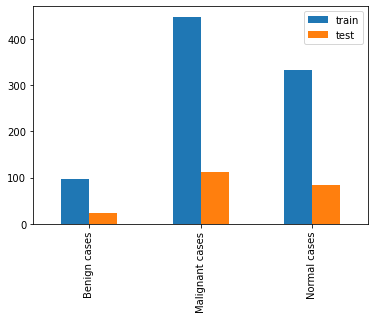

In [7]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'train': train_counts,
              'test': test_counts}, 
             index=class_names).plot.bar()

plt.show()

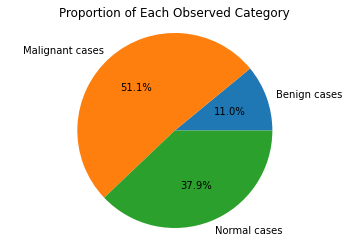

In [8]:
plt.pie(train_counts,
        explode=None, 
        labels=class_names,
        autopct='%1.1f%%')

plt.axis('equal')
plt.title('Proportion of Each Observed Category')
plt.show()

# Data Preprocessing

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Transfer Learning Feature Extraction -- VGG16

In [10]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

In [11]:
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [12]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

### Make Data 1D for compatability with Standard Classifiers

In [13]:
X_trainShape = train_features.shape[1]*train_features.shape[2]*train_features.shape[3]
X_testShape = test_features.shape[1]*test_features.shape[2]*test_features.shape[3]

X_trainFlat = train_features.reshape(train_features.shape[0], X_trainShape)
X_testFlat = test_features.reshape(test_features.shape[0], X_testShape)

# Machine Learning Models

# XGBoost

In [14]:
from xgboost import XGBClassifier

In [15]:
start_time = time.time()
xgb = XGBClassifier()
xgb.fit(X_trainFlat, train_labels)
print (time.time() - start_time, "seconds")

C:\Users\nafem\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
300.62935853004456 seconds


In [16]:
y_pred4 = xgb.predict(X_testFlat)

In [17]:
from sklearn.metrics import accuracy_score
accuracy = {accuracy_score(test_labels, y_pred4)}
print(f"Accuracy is: {accuracy_score(test_labels, y_pred4)* 100}")

Accuracy is: 99.5475113122172


Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       1.00      1.00      1.00       113
           2       0.99      1.00      0.99        84

    accuracy                           1.00       221
   macro avg       1.00      0.99      0.99       221
weighted avg       1.00      1.00      1.00       221

Confusion Matrix : 


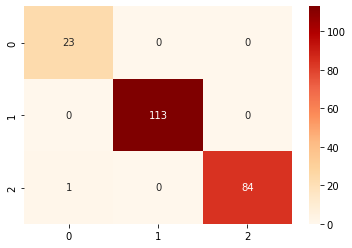

In [18]:
print('\033[1m' +'Classification report : '+ '\033[0m\n', classification_report(test_labels, y_pred4))

cm = confusion_matrix(y_pred4, test_labels)
print('\033[1m' +'Confusion Matrix : '+ '\033[0m')
sns.heatmap(cm, cmap = 'OrRd',annot = True, fmt='d')
plt.show()

# Evaluation -- XGBoost

In [19]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(test_labels,y_pred4))
print('MSE:', metrics.mean_squared_error(test_labels, y_pred4))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_labels, y_pred4)))

MAE: 0.00904977375565611
MSE: 0.01809954751131222
RMSE: 0.1345345587992625


In [20]:
from sklearn.metrics import precision_score
print("Precision Score : ",precision_score(test_labels, y_pred4, average='weighted'))


from sklearn.metrics import recall_score
print("Recall Score : ",recall_score(test_labels, y_pred4,average='weighted'))


from sklearn.metrics import f1_score
print("f1_score : ",f1_score(test_labels, y_pred4,average='weighted'))

Precision Score :  0.9955283470854405
Recall Score :  0.995475113122172
f1_score :  0.9954403632670105
